## Importing Libraries

In [1]:
# !pip install umap --user
# !pip install umap-learn --user
# !pip install hdbscan --user
# !pip install datasets --user
# !pip install sentence_transformers --user
# !pip install gensim --user

# !pip install openai --user

In [2]:
import os
import re
import openai
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from datasets import load_dataset
from gensim.utils import simple_preprocess
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [3]:
ag_news_dataset = load_dataset("ag_news", split = "test")

ag_news_dataset.shape

(7600, 2)

In [4]:
df = pd.DataFrame(ag_news_dataset)

df.head()

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


## Data Exploration

<AxesSubplot: xlabel='label', ylabel='count'>

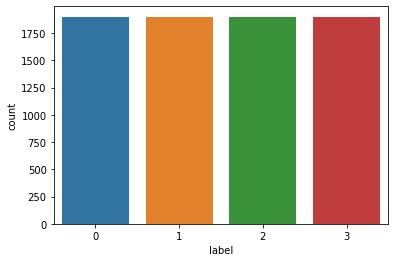

In [5]:
sns.countplot(x = "label", data = df)

## Creating Text Embedding using Sentence Transformer

In [6]:
text_data = df["text"].values.tolist()

In [7]:
embedding_model = SentenceTransformer("BAAI/bge-small-en")

text_embedding = embedding_model.encode(text_data)

df['embeddings'] = list(text_embedding)

## Creating UMAP Model for dimentsionallity reduction of embedding

In [8]:
umap_model = UMAP()

## Finding optimal values of hyper parameters

In [9]:
param_grid = {"n_neighbors": [10, 15, 20],
              "n_components": [5, 10],
              "min_dist": [0.0],
              "metric": ["cosine"]}

In [10]:
grid_search = GridSearchCV(estimator = umap_model, 
                           param_grid = param_grid, 
                           scoring = "neg_mean_squared_error", 
                           n_jobs=-1)

grid_result = grid_search.fit(text_embedding)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [11]:
best_params = grid_result.best_params_

print("Best Parameters:", best_params)

Best Parameters: {'metric': 'cosine', 'min_dist': 0.0, 'n_components': 5, 'n_neighbors': 10}


# Getting the best UMAP model

In [12]:
best_umap_model = grid_search.best_estimator_

reduced_text_embeddings = best_umap_model.fit_transform(text_embedding)

In [13]:
reduced_text_embeddings

array([[ 0.42186838,  6.9067264 ,  9.8567505 ,  5.420211  ,  4.922859  ],
       [ 1.3872406 ,  5.959768  ,  6.12122   ,  5.4796906 ,  6.789495  ],
       [ 2.1640227 ,  5.0856957 ,  8.273305  ,  6.003732  ,  5.9640594 ],
       ...,
       [ 9.526985  ,  8.77339   ,  8.944992  ,  6.2016544 ,  4.523805  ],
       [ 1.3686178 ,  6.530802  ,  9.016346  ,  6.4238048 ,  5.806661  ],
       [-0.20695533,  8.248624  ,  9.866949  ,  6.187445  ,  6.0310135 ]],
      dtype=float32)

## Clustering in the embedding using HDBSCAN

In [38]:
del min_cluster_sizes, min_samples_values

In [39]:
min_cluster_sizes = [5, 15, 25, 40]
min_samples_values = [5, 10, 15, 20]

best_score = -1
best_params = {}

for min_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        clusterer = HDBSCAN(min_cluster_size=min_size, min_samples=min_samples)
        cluster_labels = clusterer.fit_predict(reduced_text_embeddings)

        silhouette_avg = silhouette_score(reduced_text_embeddings, cluster_labels)

        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params['min_cluster_size'] = min_size
            best_params['min_samples'] = min_samples
            
print(f"Best Parameters: {best_params}")

Best Parameters: {'min_cluster_size': 40, 'min_samples': 5}


In [15]:
hdbscan_model = HDBSCAN(min_cluster_size = 40,
                        min_samples = 5,
                        metric = "euclidean")

cluster = hdbscan_model.fit(reduced_text_embeddings)

df["cluster"] = cluster.labels_

print(set(cluster.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, -1}


In [16]:
df["cluster"].nunique()

51

In [48]:
df.head(5)

,text,label,embeddings,cluster
0,Fears for T N pension after talks Unions repre...,2,"[-0.0146473, 0.006970333, -0.051307015, 0.0033...",-1
1,The Race is On: Second Private Team Sets Launc...,3,"[-0.029728416, 0.012254529, -0.0025097, 0.0022...",1
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,"[-0.07780378, -0.039871886, 0.028934998, -0.00...",19
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,"[-0.024811884, -0.010302949, 0.039535075, 0.01...",9
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,"[0.012375273, -0.0046601864, 0.042067915, -0.0...",19


## Documents extraction from each cluster

In [28]:
top_n = 10
diversity = 0.5
cluster_dict = {}

for cluster, x in df.groupby('cluster'):
    if cluster == -1:
        continue

    # find the most representative documents
    # calculating cosine similarity of the embeddings
    candidate_d = cosine_similarity(x['embeddings'].tolist(), x['embeddings'].tolist())
    # summing up cosine distance row wise
    candidate_d_sum = candidate_d.sum(axis=1)
    # finding the maximum index
    doc_list = [np.argmax(candidate_d.sum(axis=1))]
    candidates_idx = [i for i in range(len(x)) if i != doc_list[0]]

    # filter based on maximal marginal relevance
    for _ in range(top_n - 1):
        candidate_similarities = candidate_d.sum(axis=1)[candidates_idx]
        target_similarities = np.max(candidate_d[candidates_idx][:, doc_list], axis=1)

        # Calculate MMR
        mmr = (1 - diversity) * candidate_similarities - diversity * target_similarities
        # Update keywords & candidates
        mmr_idx = candidates_idx[np.argmax(mmr)]
        doc_list.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    cluster_dict[cluster] = {'doc': [x['text'].tolist()[idx] for idx in doc_list]}

In [29]:
cluster_dict[0]

{'doc': ['Tigers #39; challenge: Win out or lose out Satchel Paige said don #39;t look back because something might be gaining on you. Satch was a baseball pitcher, not a football coach.',
  'GAME NOTES: The 24th-ranked Memphis Tigers and the fifth-ranked &lt;b&gt;...&lt;/b&gt; Orange are set to square off in the title game of the Coaches vs. Cancer. Classic. The Orange posted an impressive 71-58 victory over 12th-ranked.',
  'C #39;s open with dang: Squander 18-point lead in loss to Sixers This is getting monotonous. For the second straight night, a candidate from Boston was looking good after some exit polling, but when the last points/votes were counted, the opponent had the plurality.',
  'Orioles to get paid off for Expos #39; move to DC In this crevice of the baseball globe, as the season heads to the bottom of the ninth, nothing has changed. It #39;s an annual rite for both teams by the bay to be in prime playoff position with a week to go, and ',
  "Red Sox Feeling Heat of 0-2 

## Importing Open AI libraries

In [20]:
import os
import openai
from langchain.llms import OpenAI
import requests
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage

## Setting up the enviornment variables

In [21]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Defining the LLM model

In [32]:
def get_reponse(prompt, temperature = 0):
    response = openai.ChatCompletion.create(engine = "gpt-35-turbo",
                                            messages = [{"role": "user", "content": prompt}],
                                            temperature = 0,
                                            max_tokens = 100)
    return (response.choices[0].message.content)

## Creating the title of the topic using LLM

In [33]:
for i in cluster_dict.keys():

    # prompt
    documents = "\n".join([f"{c + 1}.{text}" for c, text in enumerate(cluster_dict[i]['doc'])])
    delimiter = "****"
    prompt = f"""\
    You will be provided with multiple documents that form the same cluster. \
    The documents will be delimited with {delimiter} characters. \
    Your task is to define a topic title that is well representing all the listed documents.\
    Output starts with 'Title: '
    Documents: {delimiter}{documents}{delimiter}
    """

    # response from openai
    llm_output = get_reponse(prompt)
    cluster_dict[i]["topic"] = llm_output

## Testing the result

In [47]:
idx = 7

print(cluster_dict[idx]["topic"])
print("\n")
for i, d in enumerate(cluster_dict[idx]["doc"]):
    print(f"{i}. {d} \n")

Title: Australian dominance in cricket


0. Langer leads the Australian charge Justin Langer #39;s coruscating unbeaten 181 shone through on an enthralling day of Test cricket when Australia demonstrated, once again, why they are by far the best side in the world. 

1. Zimbabwe do England a favour Zimbabwe have been English cricket #39;s bte noir over the past year but here yesterday, they did them a huge favour in the Champions Trophy, despite losing to Sri Lanka by four  

2. TV war puts tour of India in doubt Australian cricket chiefs fear a battle over television rights could cause next month #39;s Test series in India to be cancelled, and last night were seeking clarification from Indian board president  

3. UPDATE 1-Australia survive NZ flurry to square series Australia withstood a late flurry of exciting strokeplay from pace bowler Kyle Mills to beat New Zealand by 17 runs in Wednesday #39;s second limited-overs international to square their best-of-three series at 1-1. 

4. CR